# Final cosmology results
This notebook samples the posterior distribution and makes the plotting of the results. The notebook requires the cosmology sampling built in lenstronomy and an additional less mentained package 'myplot', available on the github repo of Simon Birrer (sibirrer).
If you want to overplot the Planck chains, you have to download them from the Planck website.

In [1]:
import numpy as np
import numpy.testing as npt
import pickle
import corner
from lenstronomy.Cosmo.lens_cosmo import LCDM
from lenstronomy.Cosmo.cosmography import MCMCSampler
import lenstronomy.Util.prob_density as prob_density

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
# ====================================
# LENS REDSHIFTS AND DEFAULT COSMOLOGY
# ====================================

# redshifts of lens and source of SDSS J1206
z_d = 0.745
z_s = 1.789
# we initialise a general cosmology class able to compute the cosmological quantities 

cosmoProp = LCDM(z_lens=z_d, z_source=z_s)

## Reading in the actual samples
make sure that the files containing the posteriors are in the same folder as the notebook
or otherwise add the relative path when you read in the particles.

available samples are:

- 'final': THE FINAL sample of the BIC criteria with stochasticity accounted for.

- 'marginalize_all': just take all the 128 samples, uniformly weight them and see what happens. This is NOT the best way to do it. All it says is that the subset of the 'final'  sample is included there.

- 'final_power_law': This are the posteriors of the 'final' sample, but only the power-law lens models. If you believe in power-law models: Take this one! (not recommended)

- 'final_composite': This are the posteriors of the 'final' sample, but only the composite lens models. If you believe in composite models: Take this one! (not recommended neither)

- 'test': This is a sample I generated to make you use this notebook before the other options are available. Just for fun!



In [3]:
sample_name = 'final'

# we import posterior samples from the analysis
# _option_2
D_dt_samples = np.load(sample_name+'_D_dt.npy')
D_d_samples = np.load(sample_name+'_D_d.npy')
D_d_uniform_samples = np.random.uniform(low=0, high=5000, size=len(D_d_samples))
D_dt_uniform_samples = np.random.uniform(low=0, high=200000, size=len(D_d_samples))
D_d_uncorrelated_samples = np.random.permutation(D_d_samples)

print(np.shape(D_d_uncorrelated_samples), np.shape(D_d_samples))
print("the number of posteriors in the sample is %s" % len(D_d_samples))

(67570,) (67570,)
the number of posteriors in the sample is 67570


## The actual sample on default values
Now it's time to read in the real posteriors! We read in the actual posterior sample, but wait, to test whether also on the real sample everything works fine, we first median subtract the posteriors and then put them on our default cosmology - just to see whether everything works as expected. So we set blinded=True and only afterwards we set blinded=True 

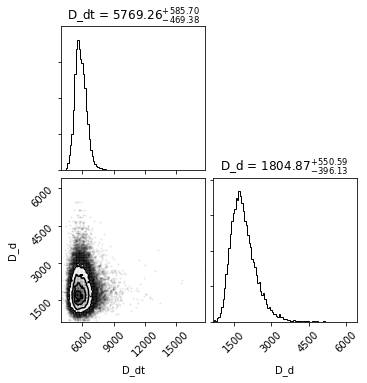

In [4]:

D_d_samples_run = D_d_samples
D_dt_samples_run = D_dt_samples
    
samples_merged = np.zeros((len(D_dt_samples_run), 2))
samples_merged[:, 0] = D_dt_samples_run
samples_merged[:, 1] = D_d_uncorrelated_samples

corner.corner(samples_merged, show_titles=True, labels=['D_dt', 'D_d'], bins=100)
plt.show()

Computing the MCMC...
Number of walkers =  200
Burn-in itterations:  200
Sampling itterations: 200


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)


InMemoryStorageUtil does not support storeRandomState
169.94275307655334 time taken for MCMC sampling


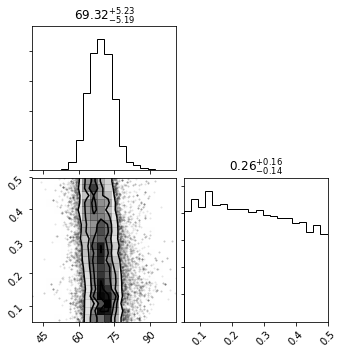

In [5]:
# sampling H0, Omega_m within [0.05, 0.5]
lower_limit = [0, 0.05]
upper_limit = [150, 0.5]

bandwidth = 2
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov'
mcmc_sampler = MCMCSampler(z_d, z_s, D_d_samples_run, D_dt_samples_run,
                           sampling_option="H0_omega_m", kde_type=kde_type,
                           bandwidth=bandwidth, flat=True, lower_limit=lower_limit, upper_limit=upper_limit)
walkerRatio = 100
n_run = 200
n_burn = 200
mean_start = [70, 0.3]
sigma_start = [10, 0.1]
mcmc_samples_cosmo_narrow = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)

corner.corner(mcmc_samples_cosmo_narrow, show_titles=True)
plt.show()

Computing the MCMC...
Number of walkers =  200
Burn-in itterations:  400
Sampling itterations: 400


/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)


InMemoryStorageUtil does not support storeRandomState
345.4849500656128 time taken for MCMC sampling


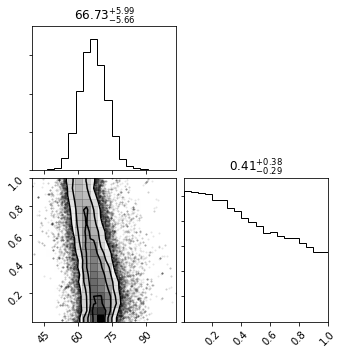

(66.72682330486387, [[5.505676358752439, 5.825708672264156], [11.229534729622387, 12.762198680302788], [18.277639665544676, 23.67358742364209]])


In [6]:
# sampling H0, Omega_m within [0., 1]
lower_limit = [0, 0.0]
upper_limit = [150, 1.]

mcmc_sampler = MCMCSampler(z_d, z_s, D_d_samples_run, D_dt_samples_run,
                           sampling_option="H0_omega_m", kde_type=kde_type,
                           bandwidth=bandwidth, flat=True, lower_limit=lower_limit, upper_limit=upper_limit)
walkerRatio = 100
n_run = 400
n_burn = 400
mean_start = [70, 0.3]
sigma_start = [10, 0.1]
mcmc_samples_cosmo_wide = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)

corner.corner(mcmc_samples_cosmo_wide, show_titles=True)
plt.show()
print(prob_density.compute_lower_upper_errors(mcmc_samples_cosmo_wide[:, 0], num_sigma=3))

Computing the MCMC...
Number of walkers =  120
Burn-in itterations:  200
Sampling itterations: 200
InMemoryStorageUtil does not support storeRandomState
104.36709380149841 time taken for MCMC sampling


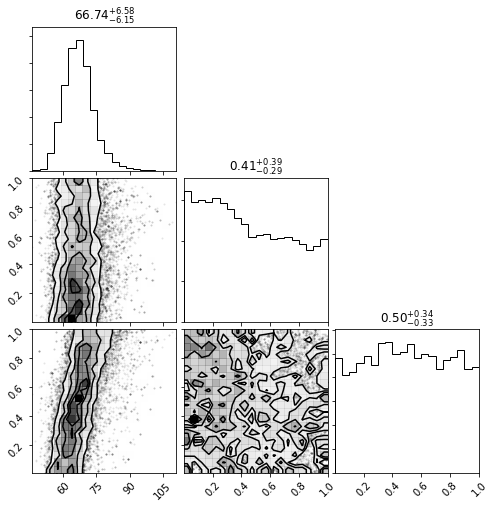

In [7]:
# for fun we run a non-flat LCDM model
mcmc_sampler = MCMCSampler(z_d, z_s, D_d_samples_run, D_dt_samples_run, sampling_option="H0_omega_m_omega_de", kde_type=kde_type, bandwidth=bandwidth, flat=False)
walkerRatio = 40
n_run = 200
n_burn = 200
mean_start = [70, 0.3, 0.7]
sigma_start = [10, 0.1, 0.1]
mcmc_samples_cosmo_k = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)

corner.corner(mcmc_samples_cosmo_k, show_titles=True)
plt.show()


Computing the MCMC...
Number of walkers =  80
Burn-in itterations:  200
Sampling itterations: 200


/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)


InMemoryStorageUtil does not support storeRandomState
84.92146921157837 time taken for MCMC sampling
(68.66728509349068, [[4.858913746503582, 5.239770005271154], [10.128236290612385, 11.364278148422912], [16.216296491363607, 21.470561006396167]])
68.66728509349068 4.858913746503582 5.239770005271154
7.076024252143009


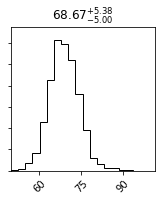

In [8]:
# and what if we fix omega_m=0.3?

mcmc_sampler = MCMCSampler(z_d, z_s, D_d_samples, D_dt_samples, sampling_option="H0_only",
                                    omega_m_fixed=0.3, kde_type=kde_type, bandwidth=bandwidth)
walkerRatio = 80
n_run = 200
n_burn = 200
mean_start = [70]
sigma_start = [10]
mcmc_samples_cosmo_1d = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)


import lenstronomy.Util.prob_density as prob_density
samples = np.reshape(mcmc_samples_cosmo_1d, len(mcmc_samples_cosmo_1d))
mean, [[lower_sigma1, upper_sigma1], [lower_sigma2, upper_sigma2], [lower_sigma3, upper_sigma3]] = prob_density.compute_lower_upper_errors(samples, num_sigma=3)
print(prob_density.compute_lower_upper_errors(samples, num_sigma=3))
print(mean, lower_sigma1, upper_sigma1)
print(lower_sigma1/mean*100)

corner.corner(mcmc_samples_cosmo_1d, show_titles=True)
plt.show()


In [9]:
# add Plank and WMAP chains

# add the WMAP and Planck chains and evaluate the angular distances as measured from the TDSL

planck_cmap = "Greens"
planck_color = "green"

wmap_cmap = "Blues"
wmap_color = "blue"


#Planck 2018
path2planck = '/Users/sibirrer/Science/Data/LCDM_posteriors/COM_CosmoParams_fullGrid_R3Planck18.00/base/plikHM_TT_lowl_lowE/base_plikHM_TT_lowl_lowE_1.txt'
temp_planck = np.loadtxt(path2planck)

#  4  omegak	\Omega_K 
#  23 H_0
#  24 omegal*	\Omega_\Lambda
#  25 omegam*	\Omega_m

num_samples = 2000

H0_planck = temp_planck[0:num_samples,23]
omegam_planck = temp_planck[0:num_samples,25]
weights_planck = temp_planck[0:num_samples,0]
weight_planck = np.zeros((num_samples))
Dd_planck = np.zeros((num_samples))
Ddt_planck = np.zeros((num_samples))
for i in range(num_samples):
    Dd_planck[i] = cosmoProp.D_d(H0_planck[i], omegam_planck[i])
    Ddt_planck[i] = cosmoProp.D_dt(H0_planck[i], omegam_planck[i])
    weight_planck[i] = weights_planck[i]

#Planck 2018 Omega_k
path2planck = '/Users/sibirrer/Science/Data/LCDM_posteriors/COM_CosmoParams_fullGrid_R3Planck18.00/base_omegak/plikHM_TT_lowl_lowE/base_omegak_plikHM_TT_lowl_lowE_1.txt'
temp_planck = np.loadtxt(path2planck)

#  4  omegak	\Omega_K 
#  23 H_0
#  24 omegal*	\Omega_\Lambda
#  25 omegam*	\Omega_m
num_samples = 1000
H0_planck_k = temp_planck[0:num_samples,24]
omegak_planck_k = temp_planck[0:num_samples,4]
omegal_planck_k = temp_planck[0:num_samples, 25]
omegam_planck_k = temp_planck[0:num_samples,26]
weights_planck_k = temp_planck[0:num_samples,0]
    
weight_planck = np.zeros((num_samples))
Dd_planck_k = np.zeros((num_samples))
Ddt_planck_k = np.zeros((num_samples))
cosmoProp_k = LCDM(z_lens=z_d, z_source=z_s, flat=False)

for i in range(num_samples):
    Dd_planck_k[i] = cosmoProp_k.D_d(H0_planck_k[i], omegam_planck_k[i], omegal_planck_k[i])
    Ddt_planck_k[i] = cosmoProp_k.D_dt(H0_planck_k[i], omegam_planck_k[i], omegal_planck_k[i])



In [27]:
import myplots.triangle as triangle
rc('axes', linewidth=2)

def plot_angular_distances(ax, D_dt_samples, D_d_samples, extent, plot_cmb=True, thick_size=15, curvature=False):
    cmap_tdsl = 'Greys'
    color_tdsl = 'k'
    
    extent_zoom_curved = [[np.min(Dd_planck_k),np.max(Dd_planck_k)], [np.min(Ddt_planck_k),np.max(Ddt_planck_k)]]

    extent_zoom = [[np.min(Dd_planck),np.max(Dd_planck)], [np.min(Ddt_planck),np.max(Ddt_planck)]]
    #extent = extent_zoom
    alpha = 1.
    bins = 50
    kwargs_hist = {'alpha': alpha, 'bins': bins, 'max_sample': 5000, 'alpha_off': True,
                   'sigma2': True, 'filled': True, 'plot_lines': False}
    idex = np.random.choice(len(D_d_samples), 20000)
    C = triangle.hist2d_sigma(D_d_samples[idex], D_dt_samples[idex], ax, extent, cmap=cmap_tdsl, **kwargs_hist)
    if plot_cmb is True:
        sigma_inflate = 2
        # we inflate the posteriors of the Planck chain to be seen in the graphics. This is only made to have a finite contour plot in comparision with the lensing results
        delta_Dd = np.random.normal(loc=0, size=len(Dd_planck),scale=sigma_inflate)
        delta_Dd_k = np.random.normal(loc=0, size=len(Dd_planck_k),scale=sigma_inflate)
        if curvature is True:
            C = triangle.hist2d_sigma(Dd_planck_k + delta_Dd_k, Ddt_planck_k, ax, extent_zoom_curved, cmap=wmap_cmap, **kwargs_hist)
            C = triangle.hist2d_sigma(Dd_planck + delta_Dd, Ddt_planck, ax, extent_zoom, cmap=planck_cmap, **kwargs_hist)
        else:
            C = triangle.hist2d_sigma(Dd_wmap, Ddt_wmap, ax, extent_zoom, cmap=wmap_cmap, **kwargs_hist)
            C = triangle.hist2d_sigma(Dd_planck + delta_Dd, Ddt_planck, ax, extent_zoom, cmap=planck_cmap, **kwargs_hist)
    
    ax.set_xlabel(r"$D_{\rm d}$ [Mpc]", fontsize=thick_size)
    ax.set_ylabel(r"$D_{\Delta t}$ [Mpc]", fontsize=thick_size)
    ax.xaxis.set_tick_params(labelsize=thick_size)
    ax.yaxis.set_tick_params(labelsize=thick_size)
    patch_list = []
    patch = mpatches.Patch(color=color_tdsl, label='SDSS 1206 (this work)', alpha=alpha)
    patch_list.append(patch)

    if plot_cmb is True:
        if curvature is True:
            planck_patch = mpatches.Patch(color=planck_color, label=r"Planck 2018 flat $\Lambda$CDM", alpha=alpha)
            wmap_patch = mpatches.Patch(color=wmap_color, label=r"Planck 2018 open $\Lambda$CDM", alpha=alpha) 
        else:
            wmap_patch = mpatches.Patch(color=wmap_color, label="WMAP DR9", alpha=alpha)
            planck_patch = mpatches.Patch(color=planck_color, label="Planck 2018", alpha=alpha)
        patch_list.append(planck_patch)
        patch_list.append(wmap_patch)
    ax.set_xlim(extent[0])
    ax.set_ylim(extent[1])
    ax.legend(handles=patch_list, fontsize=15, handlelength=0.9, loc=3, frameon=True,
              framealpha=0.5)
    return ax


def plot_H0_Om(ax, mcmc_samples_cosmo, extent=[[30, 100], [0, 1]], plot_cmb=True, thick_size=15, curvature=False):
    cmap_tdsl = 'Greys'
    color_tdsl = 'k'
    
    extent_zoom_curved = [[30,75], [0.1,1]]
    extent_zoom = [[np.min(H0_planck),np.max(H0_planck)], [np.min(omegam_planck),np.max(omegam_planck)]]
    alpha = 1.
    bins = 100
    kwargs_hist = {'alpha': alpha, 'bins': bins, 'max_sample': 5000, 'alpha_off': True,
                   'sigma2': True, 'filled': True, 'plot_lines': False}
    idex = np.random.choice(len(mcmc_samples_cosmo[:,0]), 20000)
    C = triangle.hist2d_sigma(mcmc_samples_cosmo[idex,0], mcmc_samples_cosmo[idex,1],
                              ax, extent, cmap=cmap_tdsl, color=color_tdsl, **kwargs_hist)
    if plot_cmb is True:
        if curvature is True:
            C = triangle.hist2d_sigma(H0_planck_k, omegam_planck_k, ax, extent_zoom_curved, cmap=wmap_cmap, **kwargs_hist)
            C = triangle.hist2d_sigma(H0_planck, omegam_planck, ax, extent_zoom, cmap=planck_cmap, **kwargs_hist)

        else:
            C = triangle.hist2d_sigma(H0_wmap, omegam_wmap, ax, extent_zoom, cmap=wmap_cmap, **kwargs_hist)
            C = triangle.hist2d_sigma(H0_planck, omegam_planck, ax, extent_zoom, cmap=planck_cmap, **kwargs_hist)

    ax.set_xlim(extent[0])
    ax.set_ylim(extent[1])
    #cmap="binary", color='k', alpha=1., bins=100, weights=None, alpha_off=False, sigma2=False,
    #             max_sample=None, filled=True, plot_lines=True
    ax.set_xlabel(r"$H_0 $[km s$^{-1}$ Mpc$^{-1}$]", fontsize=thick_size)
    ax.set_ylabel(r"$\Omega_{\rm m}$", fontsize=thick_size)
    ax.xaxis.set_tick_params(labelsize=thick_size)
    ax.yaxis.set_tick_params(labelsize=thick_size)
    patch_list = []
    patch = mpatches.Patch(color=color_tdsl, label='SDSS 1206 (this work)', alpha=alpha)
    patch_list.append(patch)

    if plot_cmb is True:
        if curvature is True:
            planck_patch = mpatches.Patch(color=planck_color, label="Planck 2018 flat $\Lambda$CDM", alpha=alpha)
            wmap_patch = mpatches.Patch(color=wmap_color, label=r"Planck 2018 open $\Lambda$CDM", alpha=alpha)
        else:
            wmap_patch = mpatches.Patch(color=wmap_color, label="WMAP DR9", alpha=alpha)
            planck_patch = mpatches.Patch(color=planck_color, label="Planck 2018", alpha=alpha)
        patch_list.append(planck_patch)
        patch_list.append(wmap_patch)
    ax.set_ylim([0.05, 0.95])
    ax.legend(handles=patch_list, fontsize=15, handlelength=0.9, loc=3, frameon=True,
              framealpha=0.5)
    return ax


def plot_1dhist(ax, samples, extent, thick_size, bins=50, label="", unit_label="", result_label="", color='k', string_result=None):

    bins = np.linspace(extent[0], extent[1], bins)
    if string_result is None:
        mean, sigma_list = prob_density.compute_lower_upper_errors(samples, num_sigma=3)
        print(mean)
        mean = round(mean, 1)
        print(mean)
        mean_string = str(mean)[:4]
        sigma_low_string = str(sigma_list[0][0])[:3]
        sigma_up_string = str(sigma_list[0][1])[:3]
        print( (sigma_list[0][0] + sigma_list[0][1]) / (2*mean), "error")
        string_result = "$" + mean_string+"_{-"+sigma_low_string+"}^{+"+sigma_up_string+"}$ "  
    ax.hist(samples, bins=bins, normed=1, histtype='step', color=color, linewidth=3, label=label + ": " + string_result + result_label)
    ax.xaxis.set_tick_params(labelsize=thick_size)
    ax.set_yticklabels([])
    ax.set_xlim([bins[0], bins[-1]])
    y_lim = ax.get_ylim()
    delta_y = y_lim[1] - y_lim[0]
    ax.set_ylim([y_lim[0], y_lim[1] + delta_y*0.2])
    ax.set_xlabel(label + " " + unit_label, fontsize=thick_size)
    ax.legend(loc=0, frameon=False, prop={'size': 20})
    ax.set_ylabel("probability density", fontsize=thick_size)
    #legend(frameon=False)
    
    return ax



1804.8683987893476
1804.9
0.25503328594103464 error
5769.264294384286
5769.3
0.08896835594521264 error


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


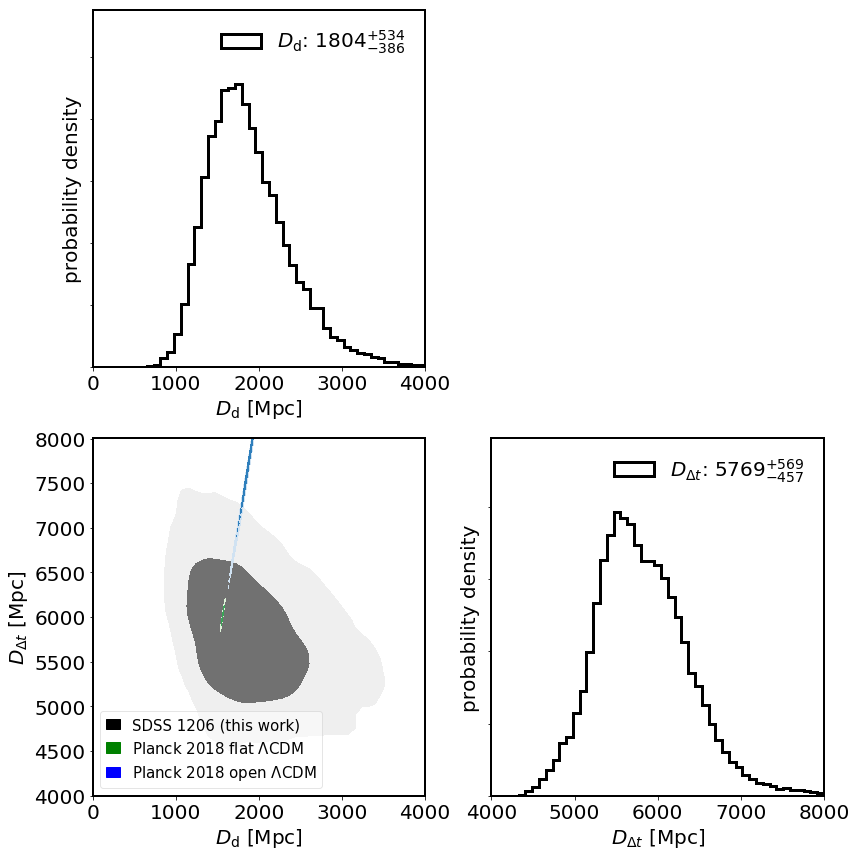

In [28]:
thick_size=20
extent_Dd = [0, 4000]
extent_Ddt = [4000, 8000]
extent = [extent_Dd, extent_Ddt]
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
plot_angular_distances(axes[1, 0], D_dt_samples, D_d_samples, extent, thick_size=thick_size, curvature=True)
ax = axes[0, 0]
plot_1dhist(ax, D_d_samples, extent=extent_Dd, thick_size=thick_size, bins=50, label=r'$D_{\rm d}$', unit_label="[Mpc]")
ax = axes[1, 1]
plot_1dhist(ax, D_dt_samples, extent=extent_Ddt, thick_size=thick_size, bins=50, label=r'$D_{\Delta t}$', unit_label="[Mpc]")

ax = axes[0, 1]
ax.set_visible(False)
ax.set_frame_on(False)
plt.tight_layout()
plt.savefig('/Users/sibirrer/Science/Projects/STRIDES/Papers/J1206cosmology/D_dt_D_d_result_v2.pdf', format='pdf')

plt.show()

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.25881615945736847
0.3
0.4880450037561975 error
0.40812600935369037
0.4
0.8080322656218399 error


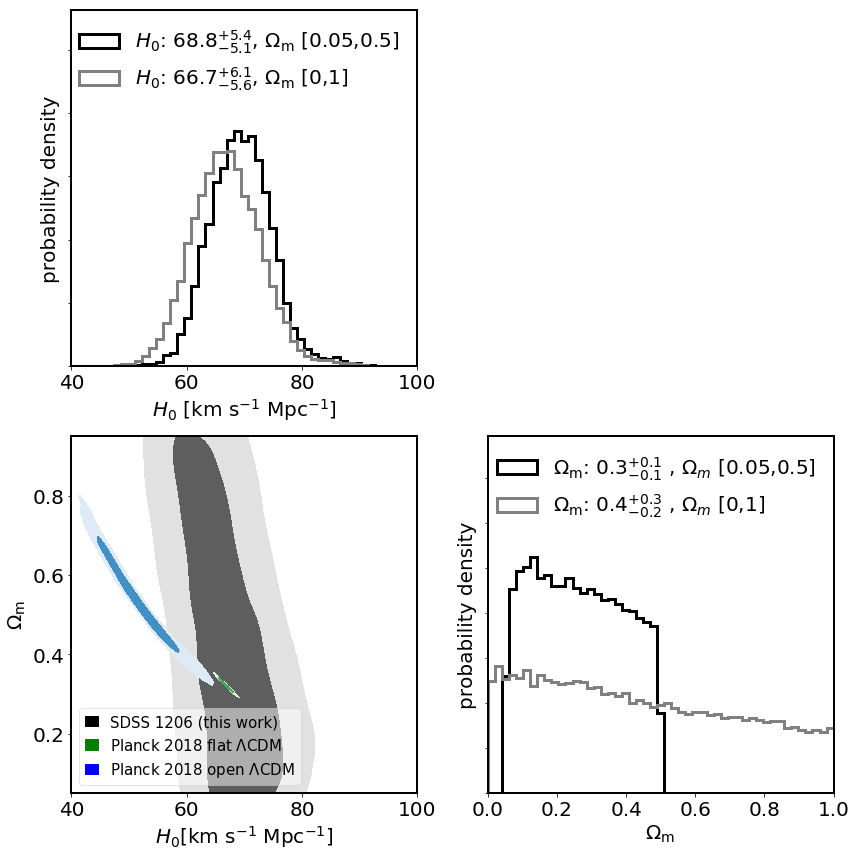

In [12]:
H0_result_narrow = r"68.8$^{+5.4}_{-5.1}$"
H0_result_wide =r"66.7$^{+6.1}_{-5.6}$"
thick_size=20
extent_H = [40, 100]
extent_Om = [0, 1]
extent = [extent_H, extent_Om]

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)

plot_H0_Om(axes[1, 0], mcmc_samples_cosmo_wide, extent=extent, thick_size=20, curvature=True)
ax = axes[0, 0]
plot_1dhist(ax, mcmc_samples_cosmo_narrow[:, 0], extent=extent_H, 
            thick_size=thick_size, bins=50, label=r'$H_0$', 
            unit_label=r'[km s$^{-1}$ Mpc$^{-1}$]', 
            result_label=r', $\Omega_{\rm m}$ [0.05,0.5]', color='k',
           string_result=H0_result_narrow)
plot_1dhist(ax, mcmc_samples_cosmo_wide[:, 0], extent=extent_H,
            thick_size=thick_size, bins=50, label=r'$H_0$', 
            unit_label=r'[km s$^{-1}$ Mpc$^{-1}$]', 
            result_label=r', $\Omega_{\rm m}$ [0,1]', color='gray',
           string_result=H0_result_wide)


ax = axes[1, 1]
plot_1dhist(ax, mcmc_samples_cosmo_narrow[:, 1], extent=extent_Om, thick_size=thick_size, bins=50, label=r'$\Omega_{\rm m}$', unit_label="", result_label=r', $\Omega_m$ [0.05,0.5]', color='k')
plot_1dhist(ax, mcmc_samples_cosmo_wide[:, 1], extent=extent_Om, thick_size=thick_size, bins=50, label=r'$\Omega_{\rm m}$', unit_label="", result_label=r', $\Omega_m$ [0,1]', color='gray')



ax = axes[0, 1]
ax.set_visible(False)
ax.set_frame_on(False)
plt.tight_layout()
#plt.savefig('/Users/sibirrer/Cosmology/Software/STRIDES/Papers/J1206cosmology/H0_omega_m_result.pdf', format='pdf')


plt.show()

Computing the MCMC...
Number of walkers =  80
Burn-in itterations:  400
Sampling itterations: 400


/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState
157.04356813430786 time taken for MCMC sampling


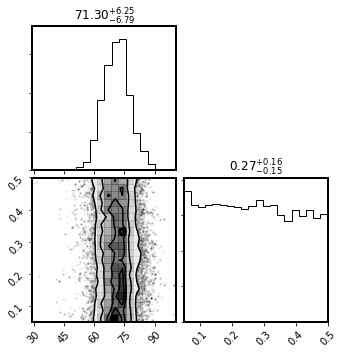

In [13]:
# sampling H0, Omega_m within [0.05, 0.5] but only D_dt marginal constraints
lower_limit = [0, 0.05]
upper_limit = [150, 0.5]

bandwidth = 2
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov'
mcmc_sampler = MCMCSampler(z_d, z_s, D_d_uniform_samples, D_dt_samples_run,
                           sampling_option="H0_omega_m", kde_type=kde_type,
                           bandwidth=bandwidth, flat=True, lower_limit=lower_limit, upper_limit=upper_limit)
walkerRatio = 40
n_run = 400
n_burn = 400
mean_start = [70, 0.3]
sigma_start = [10, 0.1]
mcmc_samples_Ddt_only = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)

corner.corner(mcmc_samples_Ddt_only, show_titles=True)
plt.show()

Computing the MCMC...
Number of walkers =  80
Burn-in itterations:  400
Sampling itterations: 400


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


InMemoryStorageUtil does not support storeRandomState


/Users/sibirrer/Software/lenstronomy/lenstronomy/Cosmo/kde_likelihood.py:43: RuntimeWarning: divide by zero encountered in log
  logL = np.log(density)


154.02301001548767 time taken for MCMC sampling


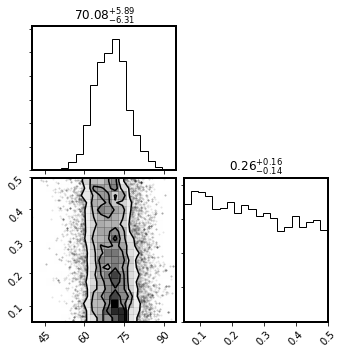

In [14]:
# sampling H0, Omega_m within [0.05, 0.5] but only D_dt marginal constraints
lower_limit = [0, 0.05]
upper_limit = [150, 0.5]

bandwidth = 2
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov'
mcmc_sampler = MCMCSampler(z_d, z_s, D_d_uncorrelated_samples, D_dt_samples_run,
                           sampling_option="H0_omega_m", kde_type=kde_type,
                           bandwidth=bandwidth, flat=True, lower_limit=lower_limit, upper_limit=upper_limit)
walkerRatio = 40
n_run = 400
n_burn = 400
mean_start = [70, 0.3]
sigma_start = [10, 0.1]
mcmc_samples_Ddt_only = mcmc_sampler.mcmc_CH(walkerRatio, n_run, n_burn, mean_start, sigma_start, threadCount=1, init_pos=None, mpi_monch=False)

corner.corner(mcmc_samples_Ddt_only, show_titles=True)
plt.show()